# Credit Score Machine Learning Model

We needed to build a model to predict credit score in order to use the Fannie Mae LLPA matrix. Before this notebook, I uploaded the data to SQLite, where I selected the appropriate columns that overlapped tghe HMDA and Fannie Mae data, and did some basic filtering. 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as geo
from mortgage import Loan 
import requests
import calendar
import math
import random
import sqlite3
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
con = sqlite3.connect(r"C:\Users\Pavan\OneDrive\Desktop\HMDAData.db")

In [3]:
cur = con.cursor()

In [4]:
query='''SELECT *
        FROM credit'''
credit=pd.read_sql_query(query, con)
credit.head()

,column20,column22,column23,column28,column31
0,95,38,769,1,44700
1,95,38,769,1,44700
2,95,38,769,1,44700
3,95,38,769,1,44700
4,95,38,769,1,44700


In [6]:
credit.dtypes

loan_to_value     object
debt_to_income    object
credit_score      object
total_units       object
dtype: object

In [7]:
credit=credit[credit["credit_score"]!='']

In [8]:
credit=credit[credit["debt_to_income"]!='']
credit=credit[credit["MSA"]!='00000']

In [9]:
len(credit["MSA"].unique())

393

In [10]:
len(credit["credit_score"].unique())

213

First, I preprocess the data, I converted to proper datatypes, and binned the data. 

In [9]:
credit["loan_to_value"]=credit["loan_to_value"].astype(float)
credit["credit_score"]=credit["credit_score"].astype(float)
credit["total_units"]=credit["total_units"].astype(str)
credit["debt_to_income"]=credit["debt_to_income"].astype(float)

In [6]:
credit.columns= ["loan_to_value","debt_to_income","credit_score","total_units","MSA"]

In [10]:
l=[]
for i in credit["debt_to_income"]: 
    if i <20: 
        l.append("<20%")
    elif i>=20 and i<30: 
        l.append("20%-<30%")
    elif i>=30 and i<36: 
        l.append("30%-<36%")
    elif i>=36 and i<41: 
        l.append("36%-<41%")
    elif i>=41 and i<46: 
        l.append("41%-<46%")
    elif i>=46 and i<50: 
        l.append("46%-<50%")
    elif i>=50 and i<=60: 
        l.append("50%-60%")
    elif i>60: 
        l.append(">60%")

In [11]:
credit["debt_to_income_ratio"]=l

In [14]:
credit["debt_to_income_ratio"].value_counts()

20%-<30%    251916
41%-<46%    227523
30%-<36%    214932
36%-<41%    214224
46%-<50%    165796
<20%         70037
50%-60%      35654
Name: debt_to_income_ratio, dtype: int64

In [13]:
credit["debt_to_income"]

50.0

In [14]:
av=credit.groupby("MSA").mean()["credit_score"]
av.head()

MSA
10180    746.121925
10380    724.777778
10420    731.569730
10500    762.544974
10540    762.322640
Name: credit_score, dtype: float64

In [15]:
credit["av_credit"]=[av[i] for i in credit["MSA"]]

C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


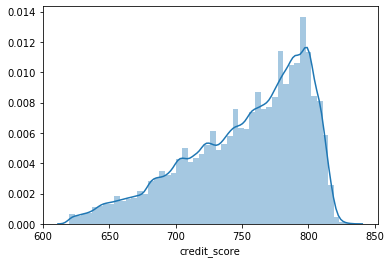

In [16]:
sns.distplot(credit["credit_score"])

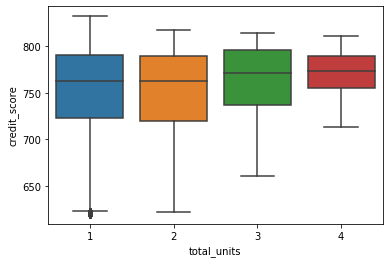

In [18]:
sns.boxplot(y="credit_score", x="total_units",data=credit);

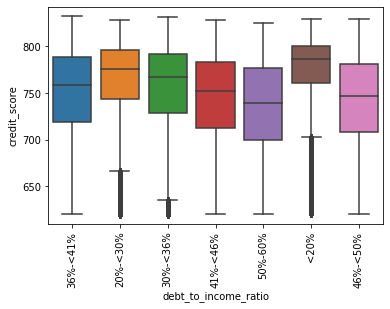

In [19]:
sns.boxplot(y="credit_score", x="debt_to_income_ratio",data=credit);
plt.xticks(rotation=90);

In [20]:
credit["bin_lv"]=pd.qcut(credit['loan_to_value'], 4,labels=["below 25th percentile","between 25th percentile and 50th percentile","between 50th percentile and 75th percentile","greater than 75th percentile"])

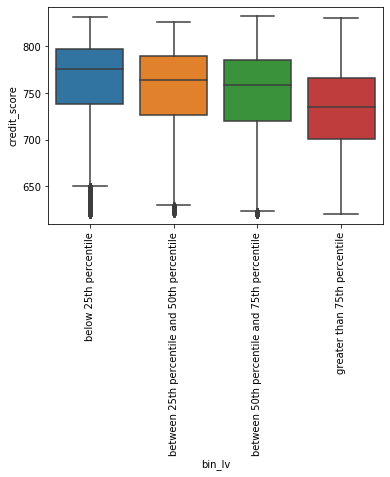

In [22]:
sns.boxplot(y="credit_score", x="bin_lv",data=credit);
plt.xticks(rotation=90);

Now, I train and test the model

In [27]:
df=credit[["bin_lv","total_units","debt_to_income_ratio","av_credit","credit_score"]]

In [28]:
X=pd.get_dummies(df[["bin_lv","debt_to_income_ratio","total_units"]])

In [39]:
X["av_credit"]= df["av_credit"]

In [40]:
from sklearn import model_selection

In [41]:
X_train, X_test, y_train, y_test=model_selection.train_test_split(X,df["credit_score"],test_size=0.20)

In [42]:
from sklearn.linear_model import LinearRegression
model= LinearRegression().fit(X_train,y_train)


In [43]:
model.coef_

array([ 3.84110551e+10,  3.84110551e+10,  3.84110551e+10,  3.84110551e+10,
       -4.63052411e+10, -4.63052411e+10, -4.63052411e+10, -4.63052411e+10,
       -4.63052411e+10, -4.63052411e+10, -4.63052410e+10,  1.10861806e+12,
        1.10861806e+12,  1.10861806e+12,  1.10861806e+12,  8.23936736e-01])

In [45]:
predict= model.predict(X_test)


In [46]:
residuals= predict-y_test


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


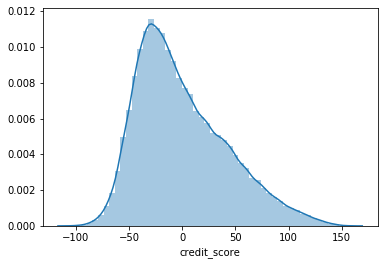

In [47]:
sns.distplot(residuals);

In [48]:
from sklearn.metrics import r2_score
print(r2_score(y_test,predict))


0.11556573350347599


In [49]:
from sklearn.metrics import mean_squared_error as mse
print(np.sqrt(mse(y_test,predict)))


42.339176877237286


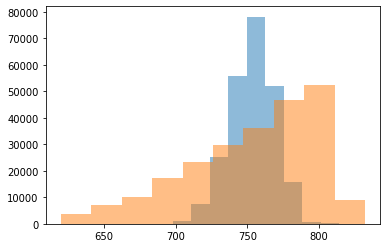

In [50]:
plt.hist(predict, alpha=0.5, label="linear");
plt.hist(y_test,alpha=0.5, label="actual");


In [57]:
from sklearn.ensemble import RandomForestRegressor
model1= RandomForestRegressor(n_estimators=300).fit(X_train,y_train)
predict1= model1.predict(X_test)
residuals1= predict1-y_test


C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


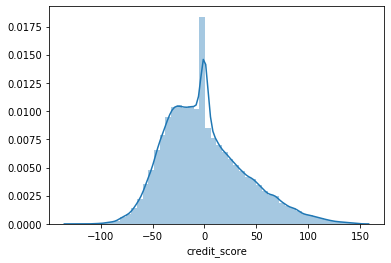

In [58]:
sns.distplot(residuals1);

In [59]:
np.sqrt(mse(y_test,predict1))

38.933970540732375

In [60]:
print(r2_score(y_test,predict1))


0.2521093027110356


In [61]:
np.std(residuals1)

38.933967865066464

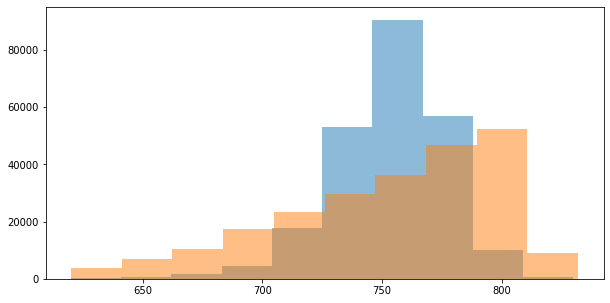

In [62]:
plt.figure(figsize=(10,5));
plt.hist(predict1, alpha=0.5, label="tree");
plt.hist(y_test,alpha=0.5, label="actual");

Save the model in a pickle file to be used in other notebook. 

In [63]:
import pickle

In [199]:
model.coef_

array([4.16988366e+10, 4.16988365e+10, 4.16988365e+10, 4.16988365e+10,
       1.19794372e+10, 1.19794372e+10, 1.19794372e+10, 1.19794372e+10,
       1.19794372e+10, 1.19794372e+10, 1.19794372e+10])

In [64]:
pkl_filename = "credit_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model1, file)

In [65]:
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [66]:
pickle_model.predict(X_test)

array([774.17563625, 716.22454844, 740.57460417, ..., 729.56209214,
       737.26506044, 775.38271204])

In [67]:
predict1

array([774.17563625, 716.22454844, 740.57460417, ..., 729.56209214,
       737.26506044, 775.38271204])

In [168]:
len(pickle_model.coef_)

15

In [195]:
len(X_test.columns)

11

In [15]:
r=["debt_to_income_ratio_30%-<36%",'debt_to_income_ratio_36%-<41%','debt_to_income_ratio_41%-<46%','debt_to_income_ratio_46%-<50%','debt_to_income_ratio_50%-60%','debt_to_income_ratio_<20%','total_units_1','total_units_2','total_units_3','total_units_4']

In [82]:
for i in range(16): 
    print(X_test.columns[i])


bin_lv_below 25th percentile
bin_lv_between 25th percentile and 50th percentile
bin_lv_between 50th percentile and 75th percentile
bin_lv_greater than 75th percentile
debt_to_income_ratio_20%-<30%
debt_to_income_ratio_30%-<36%
debt_to_income_ratio_36%-<41%
debt_to_income_ratio_41%-<46%
debt_to_income_ratio_46%-<50%
debt_to_income_ratio_50%-60%
debt_to_income_ratio_<20%
total_units_1
total_units_2
total_units_3
total_units_4
av_credit


In [69]:
len(X_test)

236017

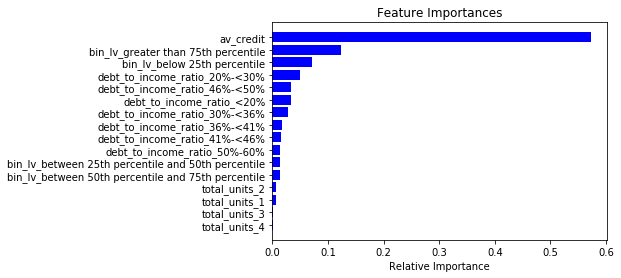

In [71]:
features = X_test.columns
importances = model1.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [81]:
pd.DataFrame(av).to_csv("avg_credit.csv")

In [80]:
credit.shape

(1180082, 8)